This notebook shows that stable rank is increasing layer by layer when neural network is learning.

In [1]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
criterion = torch.nn.MSELoss()
epochs = 2000
lr1 = 1e-3
lr2= 1e-4

N_test = 10
N_repeat = 10

kk = torch.randint(512,(N_test,))
kk = [158, 329,  47, 344, 257, 410, 426, 199, 426, 295]
#kk = [ 88, 269, 409,  59, 245, 382, 277, 362,  23, 308, 504, 448, 411, 304, 365, 200,  92, 350, 405,  77]
d = 20

losses_ = np.zeros((2,N_test,N_repeat,epochs))
sr_ = np.zeros((2,N_test,N_repeat,5,int(epochs/d)))
trn_psnr_ = np.zeros((2,N_test,N_repeat,epochs))
tst_psnr_ = np.zeros((2,N_test,N_repeat,epochs))

file_path = 'Final_1n/'

In [2]:
rgb = imread('4.2.07.tiff');im = rgb2gray(rgb);
signal_true = torch.from_numpy(im).type(torch.FloatTensor)
signal_random = torch.randn((512,512))
signals = [signal_true,signal_random]

In [3]:
width = 256

# Here define the MLP
class MLP(nn.Module):
    def __init__(self,input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fco = nn.Linear(width, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x1 = self.fc1(x)
        e1 = self.relu(x1)
        x2 = self.fc2(e1)
        e2 = self.relu(x2)
        x3 = self.fc3(e2)
        e3 = self.relu(x3)
        x4 = self.fc4(e3)
        e4 = self.relu(x4)
        out = self.fco(e4)
        return out,e4,e3,e2,e1
    def name(self):
        return "MLP"

In [4]:
def srank_func(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    sr = (s*s).sum()/s[0]/s[0]
    return sr

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def rff_embedding(x, b):
    return torch.cat((torch.sin((2.*np.pi*x) @ b.T),torch.cos((2.*np.pi*x) @ b.T)),1)

def basic_encoding(x):
    return torch.cat((torch.sin((2.*np.pi*x)),torch.cos((2.*np.pi*x))),1)

def rbf_embedding(x,dic,sig):
    return (-0.5*(x-dic)**2/sig**2).exp()

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

# no encoding

In [5]:
sample_N = 512
sample_d = 1


all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

train_data = all_data[::2*sample_d]
test_data = all_data[sample_d::2*sample_d]

# Calculate the input stable rank
sr_[:,:,:,0] = srank_func(train_data)

for i in range(2):
    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signals[i][kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = MLP(1).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), lr1, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out,e4,e3,e2,e1 = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt)[0],yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts)[0],yts)

                if epoch%d == 0:
                    es = [e1,e2,e3,e4]
                    for l in range(4):
                        sr_[i,j,k,l+1,epoch//d] = srank_func(es[l].detach().cpu())

            print("==>>> E: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,:-100]),np.mean(tst_psnr_[i,j,k,:-100]),time.time() - start_time))

==>>> E: 0, F: 0, train psnr: 18.1771--- , test psnr: 18.1705--- , time: 18.4692 seconds ---
==>>> E: 0, F: 0, train psnr: 18.2618--- , test psnr: 18.321--- , time: 32.3927 seconds ---
==>>> E: 0, F: 0, train psnr: 18.5272--- , test psnr: 18.5752--- , time: 46.7099 seconds ---
==>>> E: 0, F: 0, train psnr: 17.781--- , test psnr: 17.8098--- , time: 61.08 seconds ---
==>>> E: 0, F: 0, train psnr: 18.7177--- , test psnr: 18.7645--- , time: 75.4474 seconds ---
==>>> E: 0, F: 0, train psnr: 19.7685--- , test psnr: 19.8365--- , time: 89.8637 seconds ---
==>>> E: 0, F: 0, train psnr: 19.3584--- , test psnr: 19.3481--- , time: 104.182 seconds ---
==>>> E: 0, F: 0, train psnr: 19.4963--- , test psnr: 19.5712--- , time: 118.524 seconds ---
==>>> E: 0, F: 0, train psnr: 18.406--- , test psnr: 18.5391--- , time: 130.26 seconds ---
==>>> E: 0, F: 0, train psnr: 18.1003--- , test psnr: 18.1749--- , time: 144.736 seconds ---
==>>> E: 0, F: 1, train psnr: 22.8638--- , test psnr: 22.5428--- , time: 14.

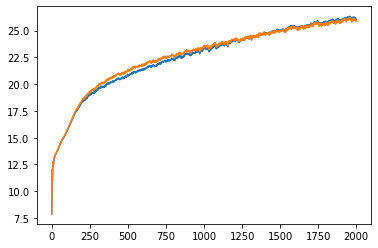

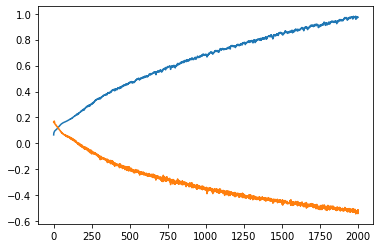

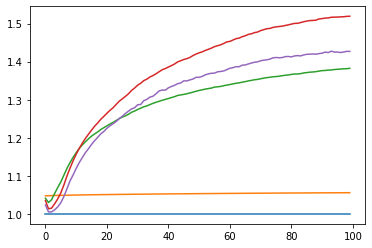

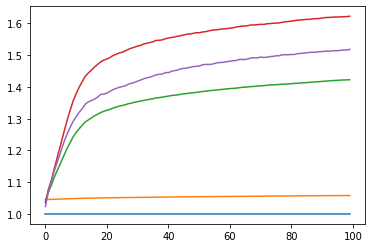

In [6]:
for i in range(2):
    figure()
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)))

for i in range(2):
    figure()
    for j in range(5):
        plot(np.mean(sr_[i,:,:,j,:],(0,1)))

In [7]:
file_name = 'no'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

# basic encoding

In [8]:
sample_N = 512
sample_d = 1

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

train_data = basic_encoding(all_data[::2*sample_d])
test_data = basic_encoding(all_data[sample_d::2*sample_d])


# Calculate the input stable rank
sr_[:,:,:,0] = srank_func(train_data)

for i in range(2):
    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signals[i][kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = MLP(2).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), lr1, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out,e4,e3,e2,e1 = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt)[0],yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts)[0],yts)

                if epoch%d == 0:
                    es = [e1,e2,e3,e4]
                    for l in range(4):
                        sr_[i,j,k,l+1,epoch//d] = srank_func(es[l].detach().cpu())

            print("==>>> E: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,:-100]),np.mean(tst_psnr_[i,j,k,:-100]),time.time() - start_time))

==>>> E: 0, F: 0, train psnr: 24.1675--- , test psnr: 24.5159--- , time: 17.5064 seconds ---
==>>> E: 0, F: 0, train psnr: 26.6947--- , test psnr: 25.7769--- , time: 34.5686 seconds ---
==>>> E: 0, F: 0, train psnr: 25.8497--- , test psnr: 25.3021--- , time: 53.3211 seconds ---
==>>> E: 0, F: 0, train psnr: 24.254--- , test psnr: 24.5632--- , time: 71.0978 seconds ---
==>>> E: 0, F: 0, train psnr: 25.3566--- , test psnr: 25.4436--- , time: 88.5656 seconds ---
==>>> E: 0, F: 0, train psnr: 25.5252--- , test psnr: 25.9611--- , time: 104.891 seconds ---
==>>> E: 0, F: 0, train psnr: 27.1904--- , test psnr: 26.4589--- , time: 123.232 seconds ---
==>>> E: 0, F: 0, train psnr: 25.0772--- , test psnr: 25.3485--- , time: 140.482 seconds ---
==>>> E: 0, F: 0, train psnr: 25.6546--- , test psnr: 25.3397--- , time: 158.203 seconds ---
==>>> E: 0, F: 0, train psnr: 25.4822--- , test psnr: 25.2689--- , time: 175.41 seconds ---
==>>> E: 0, F: 1, train psnr: 30.3502--- , test psnr: 28.1547--- , time:

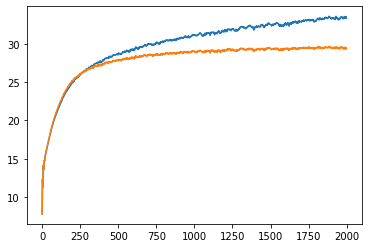

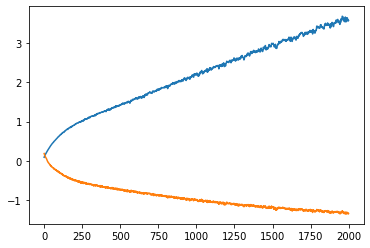

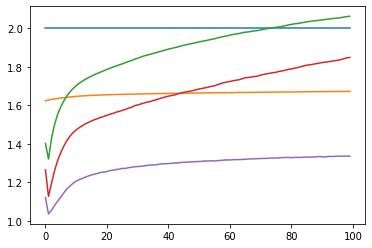

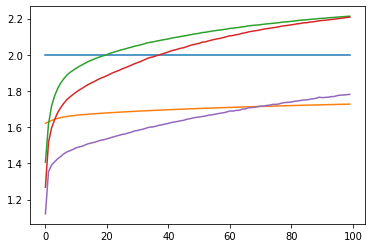

In [9]:
for i in range(2):
    figure()
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)))

for i in range(2):
    figure()
    for j in range(5):
        plot(np.mean(sr_[i,:,:,j,:],(0,1)))

In [10]:
file_name = 'basic'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

# RFF

In [11]:
sample_N = 512
sample_d = 1
embedding_dimension = 256

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

b = 5*torch.randn((int(embedding_dimension/2),1))
train_data = rff_embedding(all_data[::2*sample_d],b)
test_data = rff_embedding(all_data[sample_d::2*sample_d],b)

# Calculate the input stable rank
sr_[:,:,:,0] = srank_func(train_data)

for i in range(2):
    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signals[i][kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = MLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), lr2, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out,e4,e3,e2,e1 = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt)[0],yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts)[0],yts)

                if epoch%d == 0:
                    es = [e1,e2,e3,e4]
                    for l in range(4):
                        sr_[i,j,k,l+1,epoch//d] = srank_func(es[l].detach().cpu())

            print("==>>> E: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,:-100]),np.mean(tst_psnr_[i,j,k,:-100]),time.time() - start_time))

==>>> E: 0, F: 0, train psnr: 38.0612--- , test psnr: 28.4938--- , time: 17.8489 seconds ---
==>>> E: 0, F: 0, train psnr: 39.8602--- , test psnr: 28.5207--- , time: 35.6407 seconds ---
==>>> E: 0, F: 0, train psnr: 40.1071--- , test psnr: 28.8199--- , time: 53.5956 seconds ---
==>>> E: 0, F: 0, train psnr: 40.4706--- , test psnr: 28.7169--- , time: 71.3107 seconds ---
==>>> E: 0, F: 0, train psnr: 37.2158--- , test psnr: 28.3993--- , time: 89.1371 seconds ---
==>>> E: 0, F: 0, train psnr: 39.3646--- , test psnr: 28.7514--- , time: 107.49 seconds ---
==>>> E: 0, F: 0, train psnr: 40.0753--- , test psnr: 28.7448--- , time: 126.643 seconds ---
==>>> E: 0, F: 0, train psnr: 39.6806--- , test psnr: 28.5833--- , time: 146.643 seconds ---
==>>> E: 0, F: 0, train psnr: 38.422--- , test psnr: 28.3776--- , time: 165.256 seconds ---
==>>> E: 0, F: 0, train psnr: 38.9534--- , test psnr: 28.6588--- , time: 184.681 seconds ---
==>>> E: 0, F: 1, train psnr: 39.4488--- , test psnr: 29.7561--- , time:

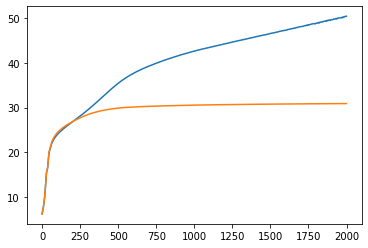

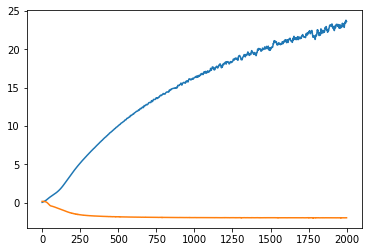

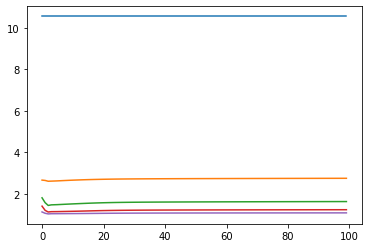

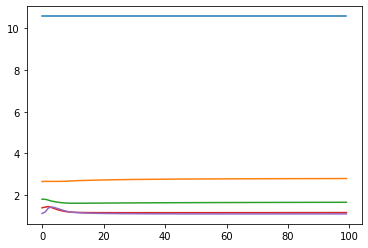

In [12]:
for i in range(2):
    figure()
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)))

for i in range(2):
    figure()
    for j in range(5):
        plot(np.mean(sr_[i,:,:,j,:],(0,1)))

In [13]:
file_name = 'rff'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

# Gaussian

In [14]:
sample_N = 512
sample_d = 1
embedding_dimension = 256

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

dic = torch.zeros((1,embedding_dimension))
sig = 0.02*torch.ones((1,embedding_dimension))
for i in range(embedding_dimension):
    dic[0,i] = i/embedding_dimension

train_data = rbf_embedding(all_data[::2*sample_d],dic,sig)
test_data = rbf_embedding(all_data[sample_d::2*sample_d],dic,sig)

# Calculate the input stable rank
sr_[:,:,:,0] = srank_func(train_data)

for i in range(2):
    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signals[i][kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = MLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), lr2, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out,e4,e3,e2,e1 = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt)[0],yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts)[0],yts)

                if epoch%d == 0:
                    es = [e1,e2,e3,e4]
                    for l in range(4):
                        sr_[i,j,k,l+1,epoch//d] = srank_func(es[l].detach().cpu())

            print("==>>> E: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,:-100]),np.mean(tst_psnr_[i,j,k,:-100]),time.time() - start_time))

==>>> E: 0, F: 0, train psnr: 37.501--- , test psnr: 28.1488--- , time: 18.8207 seconds ---
==>>> E: 0, F: 0, train psnr: 37.7388--- , test psnr: 28.2235--- , time: 36.3895 seconds ---
==>>> E: 0, F: 0, train psnr: 35.9945--- , test psnr: 27.9916--- , time: 55.1745 seconds ---
==>>> E: 0, F: 0, train psnr: 37.6136--- , test psnr: 27.8892--- , time: 74.1394 seconds ---
==>>> E: 0, F: 0, train psnr: 35.7194--- , test psnr: 27.9589--- , time: 92.2154 seconds ---
==>>> E: 0, F: 0, train psnr: 37.1377--- , test psnr: 28.2866--- , time: 110.814 seconds ---
==>>> E: 0, F: 0, train psnr: 36.1136--- , test psnr: 28.018--- , time: 129.798 seconds ---
==>>> E: 0, F: 0, train psnr: 37.5545--- , test psnr: 28.1602--- , time: 146.801 seconds ---
==>>> E: 0, F: 0, train psnr: 38.3655--- , test psnr: 28.3934--- , time: 165.845 seconds ---
==>>> E: 0, F: 0, train psnr: 37.5162--- , test psnr: 28.2012--- , time: 185.16 seconds ---
==>>> E: 0, F: 1, train psnr: 37.7592--- , test psnr: 29.3452--- , time: 

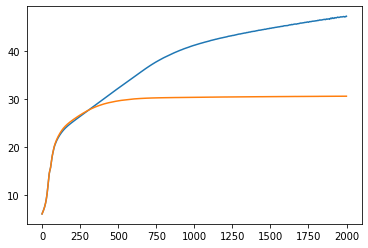

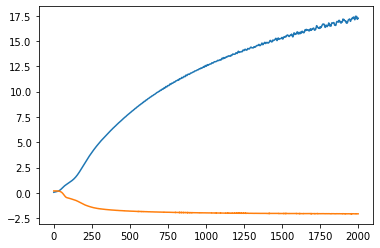

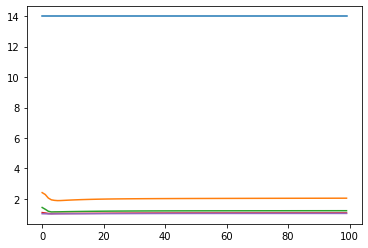

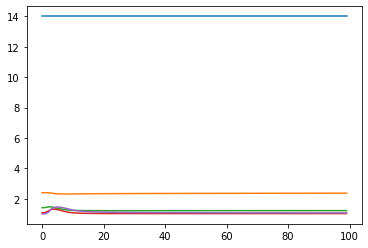

In [15]:
for i in range(2):
    figure()
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)))

for i in range(2):
    figure()
    for j in range(5):
        plot(np.mean(sr_[i,:,:,j,:],(0,1)))

In [16]:
file_name = 'rbf'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)